# IMPORTS

In [1]:
import pandas       as pd
import numpy        as np
import seaborn      as sns

import inflection
import math
import datetime
import datetime


from matplotlib             import pyplot as plt
from scipy                  import stats
from IPython.core.display   import HTML
from scipy.stats            import chi2_contingency
from sklearn.preprocessing  import RobustScaler, MinMaxScaler, LabelEncoder




%matplotlib inline

## Helper Functions

In [2]:
def jupyter_settings():
    %matplotlib inline
    %pylab inline
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    sns.set()
    jupyter_settings()

    
def cramer_v(x,y):
    cm = pd.crosstab(x,y).values
    chi2 = stats.chi2_contingency( cm )[0]
    n = cm.sum()
    r, k = cm.shape
    chi2corr = max(0,chi2 - (k-1)*(r-1)/(n-1))
    kcorr = k - (k-1)**2/(n-1)
    
    rcorr = r - (r-1)**2/(n-1)
    
    return np.sqrt((chi2/n)/ (min(kcorr-1,rcorr-1)))


## Loading Data

In [3]:
df_sales_raw = pd.read_csv('../train.csv', low_memory=False)
df_store_raw = pd.read_csv('../store.csv', low_memory=False)

# Merge
df_raw = pd.merge(df_sales_raw, df_store_raw, how = 'left', on = 'Store')

In [4]:
df_raw.sample()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
207292,1018,2,2015-01-27,10698,1231,1,1,0,0,c,c,140.0,9.0,2012.0,0,NaN,NaN,NaN


# DESCRIÇÃO DOS DADOS

## Rename Columns

In [5]:
df1 = df_raw.copy()

In [6]:
df1.columns

Index(['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval'],
      dtype='object')

In [7]:
# Colunas copiadas do df original
cols_old = ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo', 'StateHoliday', 
            'SchoolHoliday', 'StoreType', 'Assortment','CompetitionDistance', 'CompetitionOpenSinceMonth',
            'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek','Promo2SinceYear', 'PromoInterval']

In [8]:
# Alterando o nome das colunas para minusculo e separados por _
snakecase = lambda x: inflection.underscore(x)
cols_new = list(map(snakecase, cols_old))

# Renomeando as colunas
df1.columns = cols_new

In [9]:
df1.columns

Index(['store', 'day_of_week', 'date', 'sales', 'customers', 'open', 'promo',
       'state_holiday', 'school_holiday', 'store_type', 'assortment',
       'competition_distance', 'competition_open_since_month',
       'competition_open_since_year', 'promo2', 'promo2_since_week',
       'promo2_since_year', 'promo_interval'],
      dtype='object')

## Data Dimensions

In [10]:
print('Number of rows: {}'.format(df1.shape[0]))
print('Number of cols: {}'.format(df1.shape[1]))

Number of rows: 1017209
Number of cols: 18


## Data Types

In [11]:
df1.dtypes

store                             int64
day_of_week                       int64
date                             object
sales                             int64
customers                         int64
open                              int64
promo                             int64
state_holiday                    object
school_holiday                    int64
store_type                       object
assortment                       object
competition_distance            float64
competition_open_since_month    float64
competition_open_since_year     float64
promo2                            int64
promo2_since_week               float64
promo2_since_year               float64
promo_interval                   object
dtype: object

In [12]:
# Alterando a coluna 'date' para datime

df1['date'] = pd.to_datetime(df1['date'])
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
dtype: object

## Check NA

In [13]:
df1.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

## Fillout NA

In [14]:
df1['competition_distance'].max()

75860.0

In [15]:
#competition_distance
df1['competition_distance'] = df1['competition_distance'].apply(lambda x: 200000.0 if math.isnan(x) else x)

#competition_open_since_month
df1['competition_open_since_month'] = df1.apply(lambda x: x['date'].month if math.isnan(x['competition_open_since_month']) 
      else x['competition_open_since_month'], axis = 1 )

#competition_open_since_year  
df1['competition_open_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan(x['competition_open_since_year']) 
      else x['competition_open_since_year'], axis = 1 )

#promo2_since_week
df1['promo2_since_week'] = df1.apply(lambda x: x['date'].week if math.isnan(x['promo2_since_week']) 
      else x['promo2_since_week'], axis = 1 )

#promo2_since_year 
df1['promo2_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan(x['promo2_since_year']) 
      else x['promo2_since_year'], axis = 1 )

#promo_interval 
month_map = {
    1 : 'Jan',
    2 : 'Fev',
    3 : 'Mar',
    4 : 'Apr',
    5 : 'May',
    6 : 'Jun',
    7 : 'Jul',
    8 : 'Aug',
    9 : 'Sep',
    10 : 'Oct',
    11 : 'Nov',
    12 : 'Dec'}

df1['promo_interval'].fillna(0, inplace = True)
df1['month_map'] = df1['date'].dt.month.map(month_map)

df1['is_promo'] = df1[['promo_interval', 'month_map']].apply( lambda x: 0 
                                                             if x['promo_interval'] == 0 else 1 
                                                             if x['month_map'] in x['promo_interval'].split( ',' ) 
                                                             else 0, axis=1 )

In [16]:
df1.isna().sum()

store                           0
day_of_week                     0
date                            0
sales                           0
customers                       0
open                            0
promo                           0
state_holiday                   0
school_holiday                  0
store_type                      0
assortment                      0
competition_distance            0
competition_open_since_month    0
competition_open_since_year     0
promo2                          0
promo2_since_week               0
promo2_since_year               0
promo_interval                  0
month_map                       0
is_promo                        0
dtype: int64

## Change Types

In [17]:
# Alterando o tipo de dado 'int' para 'float'

df1['competition_open_since_month'] = df1['competition_open_since_month'].astype(int)
df1['competition_open_since_year'] = df1['competition_open_since_year'].astype(int)

df1['promo2_since_week'] = df1['promo2_since_week'].astype(int)
df1['promo2_since_year'] = df1['promo2_since_year'].astype(int)

In [18]:
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month             int64
competition_open_since_year              int64
promo2                                   int64
promo2_since_week                        int64
promo2_since_year                        int64
promo_interval                          object
month_map                               object
is_promo                                 int64
dtype: object

## Descriptive Statistical

In [19]:
num_attributes = df1.select_dtypes(include=['int64', 'float64'])
cat_attributes = df1.select_dtypes(exclude=['int64', 'float64' ,'datetime64[ns]'])

In [20]:
num_attributes.sample()

,store,day_of_week,sales,customers,open,promo,school_holiday,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo
531894,825,3,3079,436,1,0,0,380.0,5,2011,1,40,2014,0


In [21]:
cat_attributes.sample()

,state_holiday,store_type,assortment,promo_interval,month_map
685484,0,a,c,"Feb,May,Aug,Nov",Oct


### Numerical Attributes

In [22]:
# Central Tendency - mean, median
ct1 = pd.DataFrame(num_attributes.apply(np.mean)).T
ct2 = pd.DataFrame(num_attributes.apply(np.median)).T

# Dipersion - str, min, max, range, skew, kurtosis
d1 = pd.DataFrame(num_attributes.apply(np.std)).T
d2 = pd.DataFrame(num_attributes.apply(min)).T
d3 = pd.DataFrame(num_attributes.apply(max)).T
d4 = pd.DataFrame(num_attributes.apply(lambda x: x.max() - x.min())).T
d5 = pd.DataFrame(num_attributes.apply(lambda x: x.skew())).T
d6 = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis())).T

# concatenate
m = pd.concat([d2, d3, d4, ct1, ct2, d1, d5, d6]).T.reset_index()
m.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']
m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,store,1.0,1115.0,1114.0,558.429727,558.0,321.908493,-0.000955,-1.200524
1,day_of_week,1.0,7.0,6.0,3.998341,4.0,1.997390,0.001593,-1.246873
2,sales,0.0,41551.0,41551.0,5773.818972,5744.0,3849.924283,0.641460,1.778375
3,customers,0.0,7388.0,7388.0,633.145946,609.0,464.411506,1.598650,7.091773
4,open,0.0,1.0,1.0,0.830107,1.0,0.375539,-1.758045,1.090723
5,promo,0.0,1.0,1.0,0.381515,0.0,0.485758,0.487838,-1.762018
6,school_holiday,0.0,1.0,1.0,0.178647,0.0,0.383056,1.677842,0.815154
7,competition_distance,20.0,200000.0,199980.0,5935.442677,2330.0,12547.646829,10.242344,147.789712
8,competition_open_since_month,1.0,12.0,11.0,6.786849,7.0,3.311085,-0.042076,-1.232607
9,competition_open_since_year,1900.0,2015.0,115.0,2010.324840,2012.0,5.515591,-7.235657,124.071304


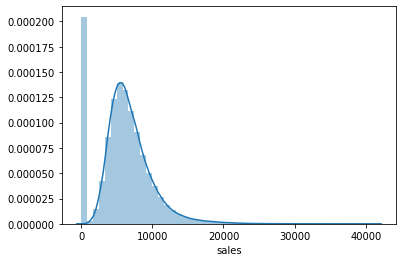

In [23]:
sns.distplot(df1['sales'])

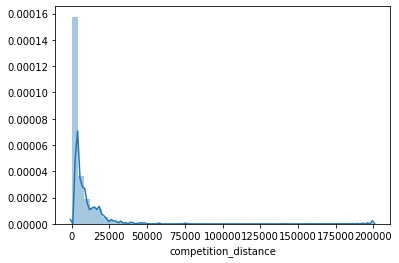

In [24]:
sns.distplot(df1['competition_distance'])

### Categorical Attributes

In [25]:
cat_attributes.apply(lambda x: x.unique().shape[0])

state_holiday      4
store_type         4
assortment         3
promo_interval     4
month_map         12
dtype: int64

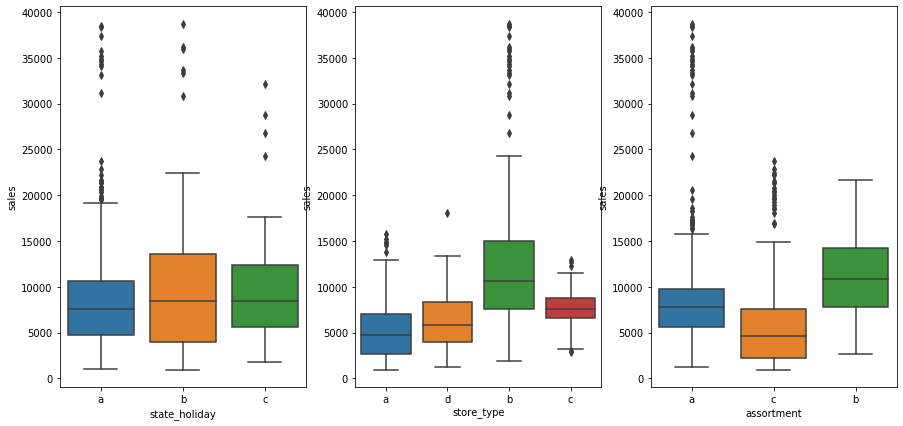

In [26]:
aux1 = df1[(df1['state_holiday'] != '0') & (df1['sales'] > 0 )]
plt.figure(figsize=(15, 7))

plt.subplot(1,3,1)
sns.boxplot(x = 'state_holiday', y = 'sales', data = aux1)

plt.subplot(1,3,2)
sns.boxplot(x = 'store_type',y = 'sales', data = aux1)

plt.subplot(1,3,3)
sns.boxplot(x = 'assortment', y = 'sales', data = aux1)

# FEATURE ENGINERRING

In [27]:
df2 = df1.copy()

## Mapa mental de hipóteses

<img width="650px" height="650px" src= 'mindmap.png'/>

## Criação das hipóteses

### Hipóteses lojas

**1.** Lojas com maior quadro de funcionarios deveriam vender mais.

**2.** Lojas com maior estoque deveriam vender mais.

**3.** Lojas com maior porte deveriam vender mais.

**4.** Lojas com menor porte deveriam vender menos.

**5.** Lojas com maior sortimento deveriam vender mais.

### Hipóteses Produto

**1.** Lojas que investem mais em Marketing deveriam vender mais.

**2.** Lojas que expoer mais os produtos nas vitrines deveriam vender mais.

**3.** Lojas que tem precos menores nos produtos deveriam vender mais.

**4.** Lojas que tem precos menores por mais tempo nos produtos deveriam vender mais.

**5.** Lojas que tem uma quantidade de estoque maior deveriam vender mais

### Hipóteses Tempo

**1.** Lojas que tem mais feriados elas deveriam vender menos.

**2.** Lojas que abrem nos primeiro 6 meses deveriam vender mais.

**3.** Lojas que abrem nos finais de semanas deveriam vender mais.

**4.** Lojas que saldao mais frequentes deveriam vender mais.

**5.** Lojas que ficam abertas por maior periodo de horas deveriam vender mais.

## Lista final de hipóteses

**1.** Lojas com maior sortimento deveriam vender mais.

**2.** Lojas com maior porte deveriam vender mais.

**3.** Lojas com menor porte deveriam vender menos.

**4.** Lojas com promocoes ativas por mais tempo deveriam vender mais.

**5.** Lojas com mais promocoes consecutivas deveriam vender mais.

**6.** Lojas com mais dias de promocao deveriam vender mais.

**7.** Lojas com abertas durante o feriado de natal deveriam vender mais.

**8.** Lojas deveriam vender mais ao longo dos anos.

**9.** Lojas deveriam vender mais no segundo semestre do ano

**10.** Lojas deveriam vender mais depois do dia 10 de cada mes.

**11.** Lojas deveriam menos aos finais de semana.

**12.** Lojas deveriam vender menos durante os feriados escolares.

**13.** Lojas com competidores mais proximos deveriam vende menos.

## Feature engineering

In [28]:
# year
df2['year'] = df2['date'].dt.year

#month
df2['month'] = df2['date'].dt.month

#day
df2['day'] = df2['date'].dt.day

# week of year
df2['week_of_year'] = df2['date'].dt.weekofyear

# year week
df2['year_week'] = df2['date'].dt.strftime('%Y-%W')

# competition since
df2['competition_since'] = df2.apply( lambda x: datetime.datetime(year =x['competition_open_since_year'] , 
                  month = x['competition_open_since_month'], day = 1), axis = 1)

df2['competition_time_month'] = ((df2['date'] - df2['competition_since']) / 30 ).apply(lambda x: x.days).astype(int)

# competition since
df2['competition_since'] = df2.apply( lambda x: datetime.datetime(year = x['competition_open_since_year'], 
                                                                  month = x['competition_open_since_month'], day = 1), axis = 1)

df2['competition_time_month'] = ((df2['date'] - df2['competition_since']) / 30 ).apply(lambda x: x.days).astype(int)

# promo since
df2['promo_since'] = df2['promo2_since_year'].astype(str) + '-' + df2['promo2_since_week'].astype(str)

df2['promo_since'] = df2['promo_since'].apply(lambda x: datetime.datetime.strptime(x + '-1', '%Y-%W-%w') - 
                                              datetime.timedelta(days = 7))

df2['promo_time_week'] = ((df2['date'] - df2['promo_since']) / 7).apply(lambda x: x.days).astype(int)

# assortment
df2['assortment'] = df2['assortment'].apply(lambda x: 'basic' if x == 'a' else 'extra' if x == 'b' else 'extended')

In [29]:
# state holiday
df2['state_holiday'] = df2['state_holiday'].apply(lambda x: 'public_holiday' 
                                                  if x == 'a' else 'easter_holiday'
                                                  if x == 'b' else 'christimas' 
                                                  if x == 'c' else 'regular_day')

In [30]:
df2.head().T

,0,1,2,3,4
store,1,2,3,4,5
day_of_week,5,5,5,5,5
date,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00
sales,5263,6064,8314,13995,4822
customers,555,625,821,1498,559
open,1,1,1,1,1
promo,1,1,1,1,1
state_holiday,regular_day,regular_day,regular_day,regular_day,regular_day
school_holiday,1,1,1,1,1
store_type,c,a,a,c,a


# FILTRAGEM DE VARIÁVEIS

In [31]:
df3 = df2.copy()

## Filtragem das linhas

In [32]:
df3 = df3[(df3['open'] != 0) & (df3['sales'] > 0)]

## Selecao das colunas

In [33]:
cols_drop = ['customers', 'open', 'promo_interval', 'month_map']
df3 = df3.drop(cols_drop, axis = 1)

In [34]:
df3.columns

Index(['store', 'day_of_week', 'date', 'sales', 'promo', 'state_holiday',
       'school_holiday', 'store_type', 'assortment', 'competition_distance',
       'competition_open_since_month', 'competition_open_since_year', 'promo2',
       'promo2_since_week', 'promo2_since_year', 'is_promo', 'year', 'month',
       'day', 'week_of_year', 'year_week', 'competition_since',
       'competition_time_month', 'promo_since', 'promo_time_week'],
      dtype='object')

# ANALISE EXPLORATÓRIA DE DADOS

In [35]:
df4 = df3.copy()

## Analise Univariada

### Response Variable

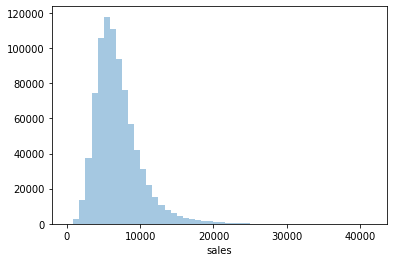

In [36]:
sns.distplot(df4['sales'], kde = False)

### Numerical variable

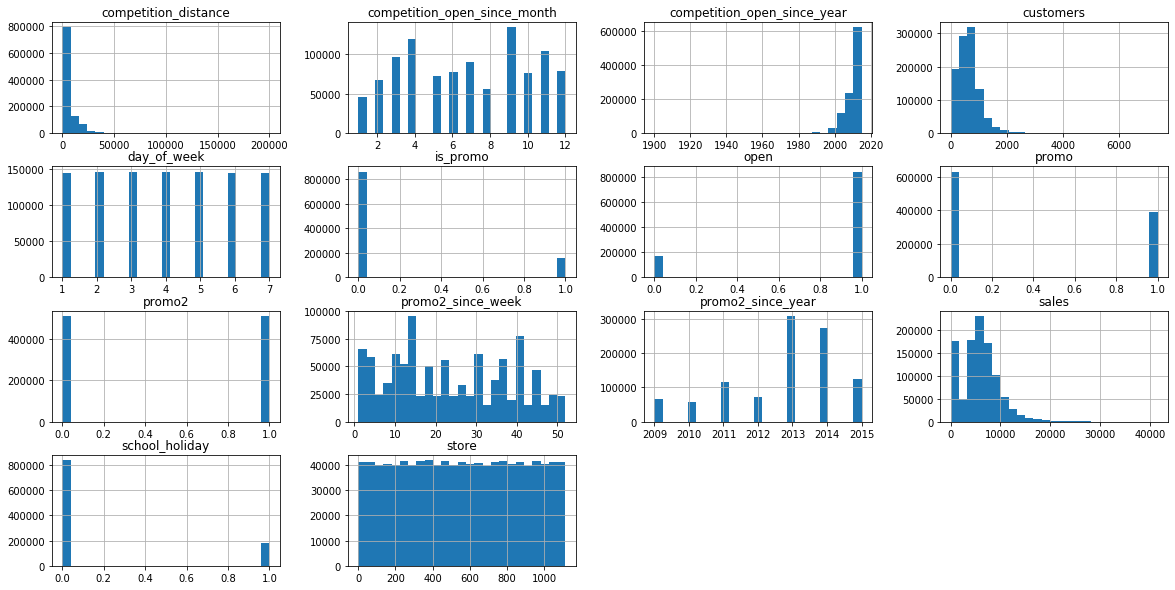

In [37]:
num_attributes.hist(bins = 25, figsize=(20,10));

### Categorcal Variable

In [38]:
df4['state_holiday'].drop_duplicates()

0            regular_day
63559     public_holiday
129424    easter_holiday
241126        christimas
Name: state_holiday, dtype: object

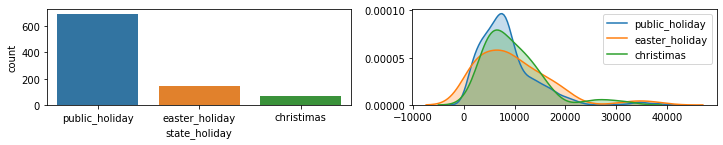

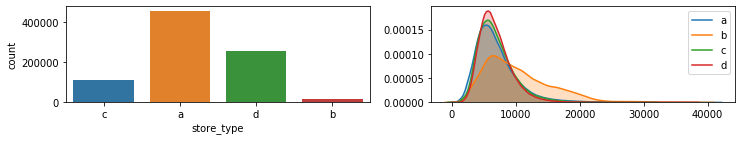

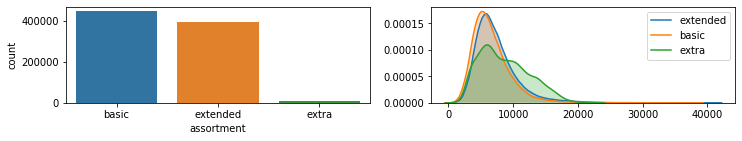

In [39]:
# State holiday
plt.figure(figsize=(12,6))
plt.subplot(3, 2, 1)
a = df4[df4['state_holiday'] != 'regular_day']
sns.countplot(a['state_holiday'])

plt.subplot(3, 2, 2)
sns.kdeplot(df4[df4['state_holiday'] == 'public_holiday']['sales'], label = 'public_holiday', shade = True)
sns.kdeplot(df4[df4['state_holiday'] == 'easter_holiday']['sales'], label = 'easter_holiday', shade = True)
sns.kdeplot(df4[df4['state_holiday'] == 'christimas']['sales'], label = 'christimas', shade = True)

#store type
plt.figure(figsize=(12,6))
plt.subplot(3, 2, 3)
a = df4[df4['store_type'] != 'regular_day']
sns.countplot(a['store_type'])

plt.subplot(3, 2, 4)
sns.kdeplot(df4[df4['store_type'] == 'a']['sales'], label = 'a', shade = True)
sns.kdeplot(df4[df4['store_type'] == 'b']['sales'], label = 'b', shade = True)
sns.kdeplot(df4[df4['store_type'] == 'c']['sales'], label = 'c', shade = True)
sns.kdeplot(df4[df4['store_type'] == 'd']['sales'], label = 'd', shade = True)

# Assortment
plt.figure(figsize=(12,6))
plt.subplot(3, 2, 5)
a = df4[df4['assortment'] != 'regular_day']
sns.countplot(a['assortment'])

plt.subplot(3, 2, 6)
sns.kdeplot(df4[df4['assortment'] == 'extended']['sales'], label = 'extended', shade = True)
sns.kdeplot(df4[df4['assortment'] == 'basic']['sales'], label = 'basic', shade = True)
sns.kdeplot(df4[df4['assortment'] == 'extra']['sales'], label = 'extra', shade = True)


## Analise Bivariada

### Lojas com mair sortimentos deveriam vender mais

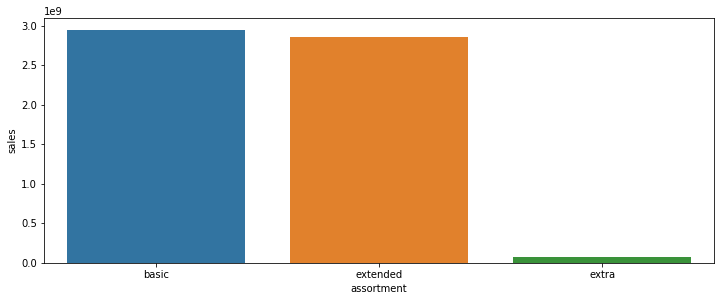

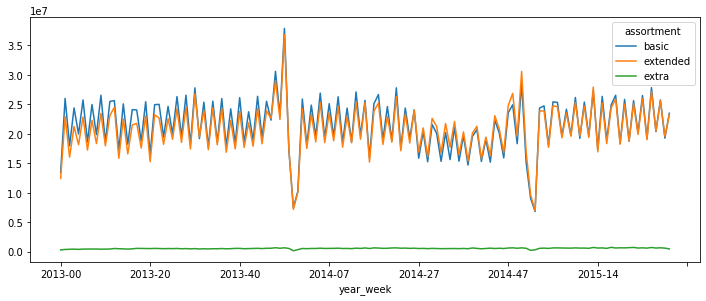

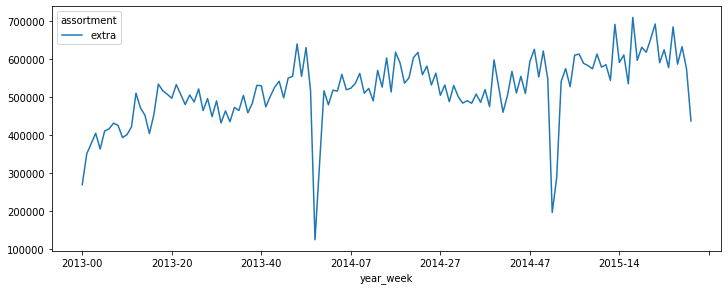

In [40]:
aux1 = df4[['assortment', 'sales']].groupby('assortment').sum().reset_index()
plt.figure(figsize=(12,4.5))
sns.barplot(x='assortment', y='sales', data = aux1);

aux2 = df4[['year_week', 'assortment', 'sales']].groupby(['year_week', 'assortment']).sum().reset_index()
aux2.pivot(index = 'year_week', columns = 'assortment', values = 'sales').plot(figsize=(12, 4.5))

aux3 = aux2[aux2['assortment'] == 'extra']
aux3.pivot(index = 'year_week', columns ='assortment', values = 'sales').plot(figsize=(12, 4.5))

### Lojas com competidores mais próximos deveram vender menos

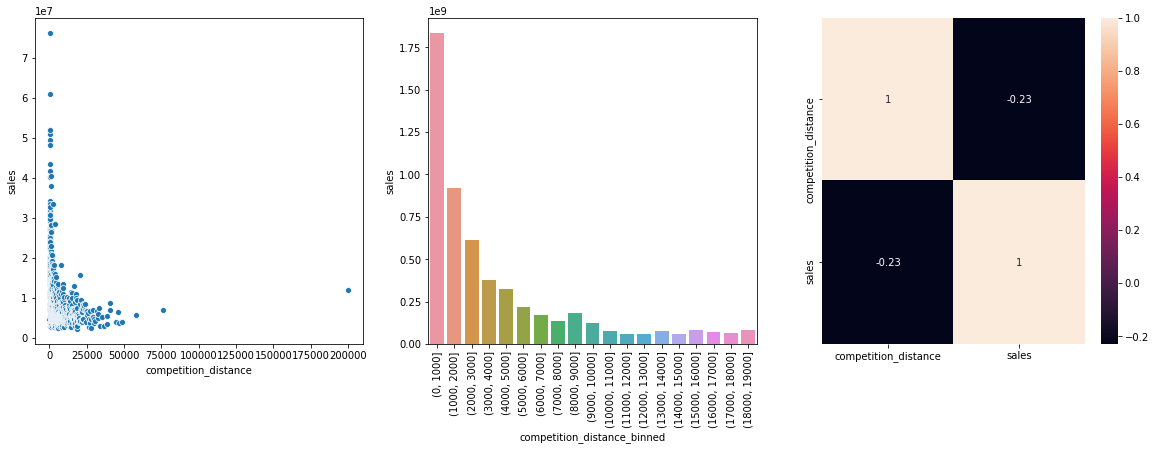

In [41]:
plt.figure(figsize=(20, 6))
aux1 = df4[['competition_distance', 'sales']].groupby('competition_distance').sum().reset_index()
plt.subplot(1, 3, 1)
sns.scatterplot(x = 'competition_distance', y='sales', data = aux1)


plt.subplot(1, 3, 2)

bins = list(np.arange(0, 20000, 1000))
aux1['competition_distance_binned'] = pd.cut(aux1['competition_distance'], bins = bins)
plt.xticks(rotation = 90)

# Somando as vendas de acordo com os bins
aux2 = aux1[['competition_distance_binned', 'sales']].groupby('competition_distance_binned').sum().reset_index()

sns.barplot(x='competition_distance_binned', y='sales', data = aux2);

plt.subplot(1, 3, 3)
sns.heatmap(aux1.corr(method='pearson'), annot = True);

### Lojas com competidores há mais tempo vendem mais

(2.5, -0.5)

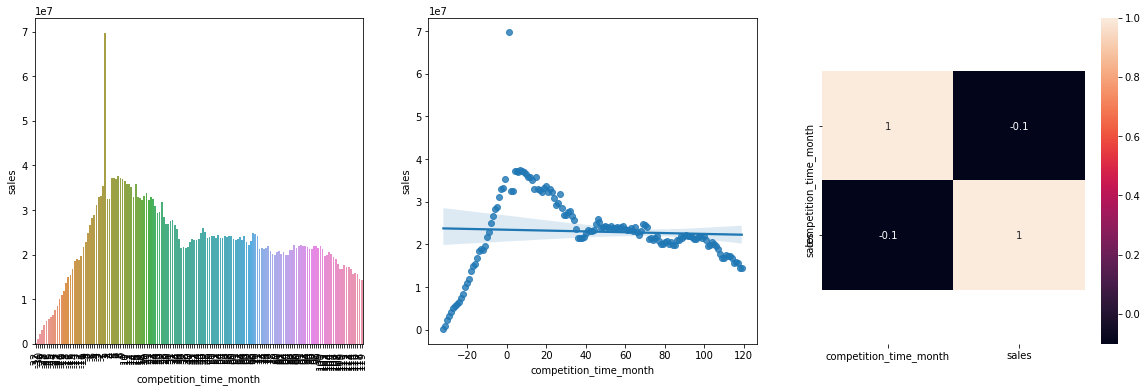

In [42]:
plt.figure(figsize=(20,6))
plt.subplot(1, 3, 1)

aux1 = df4[['competition_time_month', 'sales']].groupby('competition_time_month').sum().reset_index()
aux2 = aux1[(aux1['competition_time_month'] < 120) & (aux1['competition_time_month'] != 0)]
sns.barplot(x='competition_time_month', y = 'sales', data = aux2);
plt.xticks(rotation = 90);

plt.subplot(1, 3, 2)
sns.regplot(x='competition_time_month', y='sales', data = aux2)

plt.subplot(1, 3, 3)
x = sns.heatmap(aux1.corr(method = 'pearson'), annot = True)
bottom, top = x.get_ylim()
x.set_ylim(bottom + 0.5, top - 0.5)

### Lojas abertas durante o feriado de natal deveriam vender mais

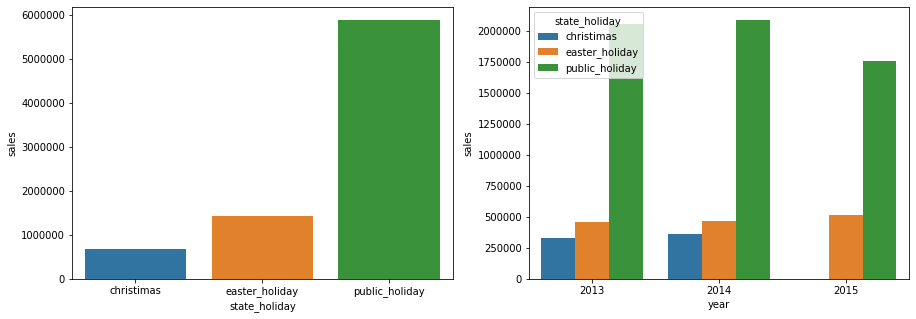

In [43]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
aux = df4[df4['state_holiday'] != 'regular_day']
aux1 = aux[['state_holiday', 'sales']].groupby('state_holiday').sum().reset_index()
sns.barplot(x = 'state_holiday', y = 'sales', data = aux1);


plt.subplot(1, 2, 2)
aux2 = aux[['year', 'state_holiday', 'sales']].groupby(['year', 'state_holiday']).sum().reset_index()
sns.barplot(x='year', y='sales', hue = 'state_holiday', data = aux2)

### Lojas deveriam vender mais ao longo dos anos

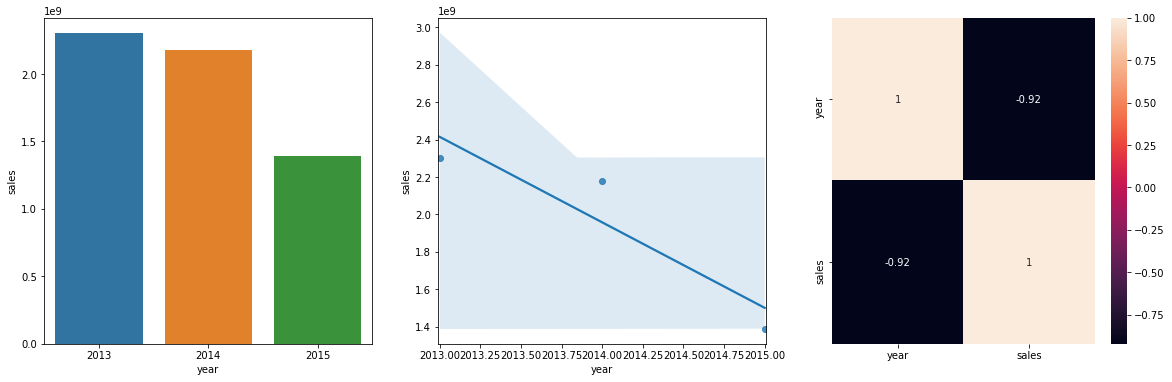

In [44]:
aux1 = df4[['year', 'sales']].groupby('year').sum().reset_index()
plt.figure(figsize =(20, 6))

plt.subplot(1, 3, 1)
sns.barplot(x = 'year', y = 'sales', data = aux1)


plt.subplot(1, 3, 2)
sns.regplot(x = 'year', y = 'sales', data = aux1);


plt.subplot(1, 3, 3)
sns.heatmap(aux1.corr(method = 'pearson'), annot = True);

### Lojas deveriam vender mais no segundo semestre do ano

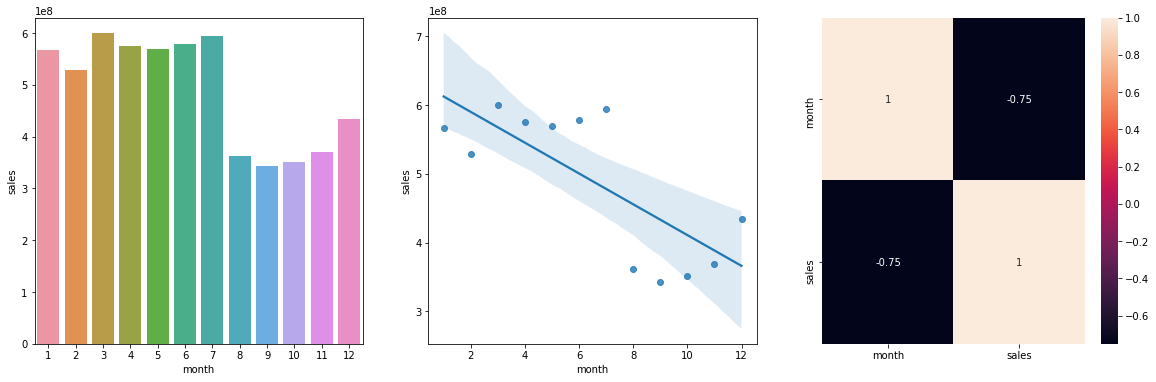

In [45]:
aux1 = df4[['month', 'sales']].groupby('month').sum().reset_index()
plt.figure(figsize =(20, 6))

plt.subplot(1, 3, 1)
sns.barplot(x = 'month', y = 'sales', data = aux1)


plt.subplot(1, 3, 2)
sns.regplot(x = 'month', y = 'sales', data = aux1);


plt.subplot(1, 3, 3)
sns.heatmap(aux1.corr(method = 'pearson'), annot = True);

### Lojas deveriam vender mais depois do dia 10 de cada mês

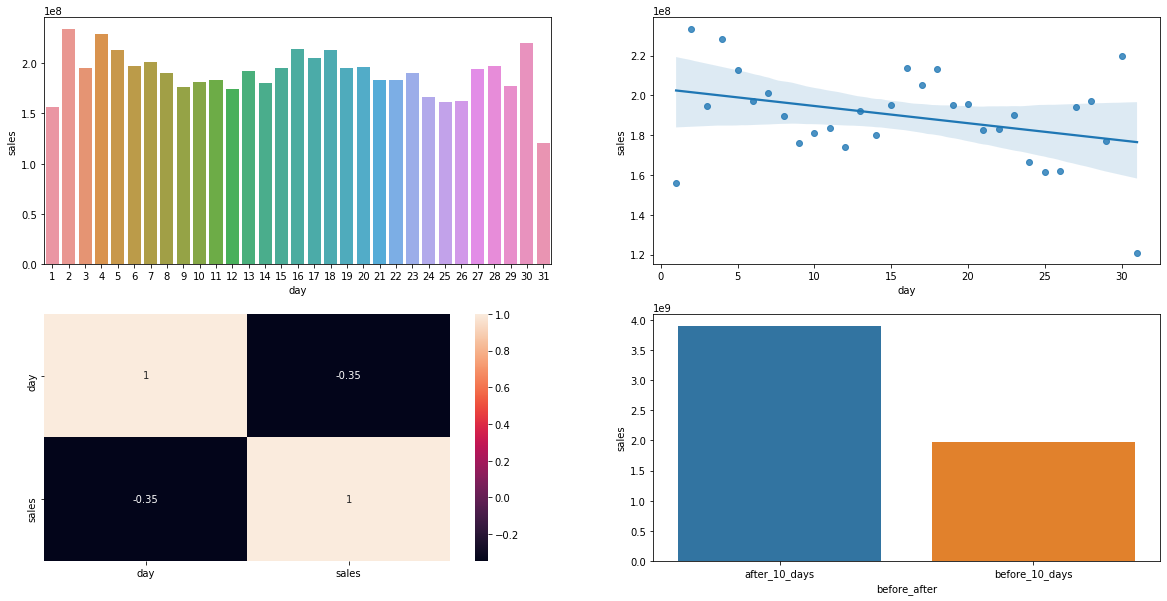

In [46]:
aux1 = df4[['day', 'sales']].groupby('day').sum().reset_index()
plt.figure(figsize =(20, 10))

plt.subplot(2, 2, 1)
sns.barplot(x = 'day', y = 'sales', data = aux1)


plt.subplot(2, 2, 2)
sns.regplot(x = 'day', y = 'sales', data = aux1);


plt.subplot(2, 2, 3)
sns.heatmap(aux1.corr(method = 'pearson'), annot = True);

plt.subplot(2, 2, 4)
aux1['before_after'] = aux1['day'].apply(lambda x: 'before_10_days' if x <= 10 else 'after_10_days')
aux2 = aux1[['before_after', 'sales']].groupby('before_after').sum().reset_index()
sns.barplot(x='before_after', y = 'sales', data = aux2)

### Lojas deveriam vender menos aos finais de semana

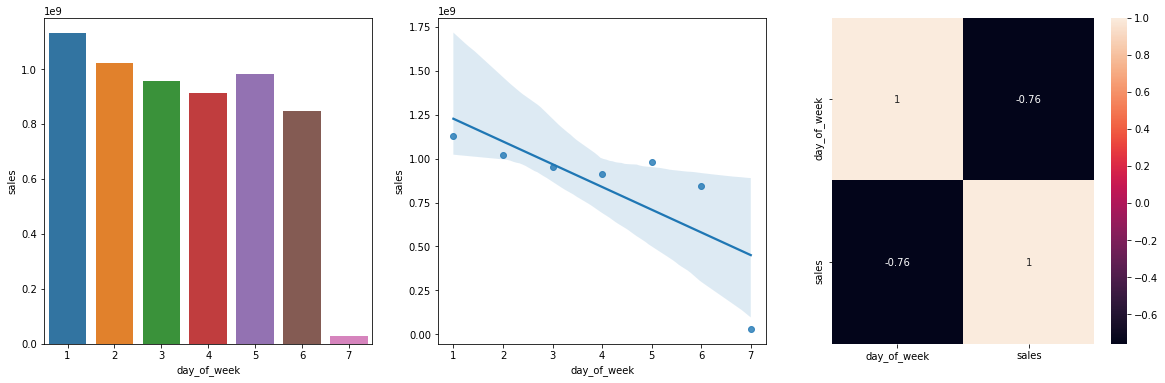

In [47]:
aux1 = df4[['day_of_week', 'sales']].groupby('day_of_week').sum().reset_index()
plt.figure(figsize =(20, 6))

plt.subplot(1, 3, 1)
sns.barplot(x = 'day_of_week', y = 'sales', data = aux1)


plt.subplot(1, 3, 2)
sns.regplot(x = 'day_of_week', y = 'sales', data = aux1);


plt.subplot(1, 3, 3)
sns.heatmap(aux1.corr(method = 'pearson'), annot = True);

### Lojas deveirma vender menos durante os feriados escolares

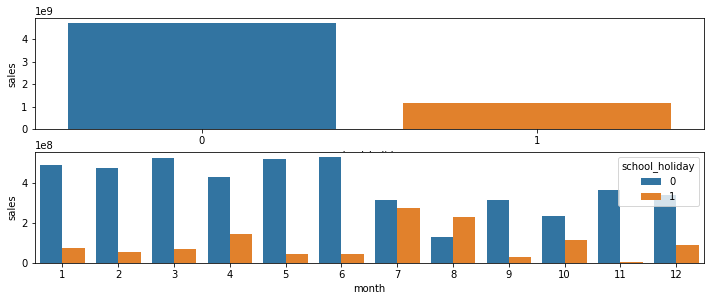

In [48]:
aux1 = df4[['school_holiday', 'sales']].groupby('school_holiday').sum().reset_index()

plt.figure(figsize=(12, 4.5))

plt.subplot(2, 1, 1)
sns.barplot(x = 'school_holiday', y = 'sales', data = aux1)

aux2 = df4[['month', 'school_holiday', 'sales']].groupby(['month', 'school_holiday']).sum().reset_index()
plt.subplot(2, 1, 2)
sns.barplot(x = 'month', y = 'sales', data = aux2, hue = 'school_holiday')

## Analise Multivariada

### Numerical attributes

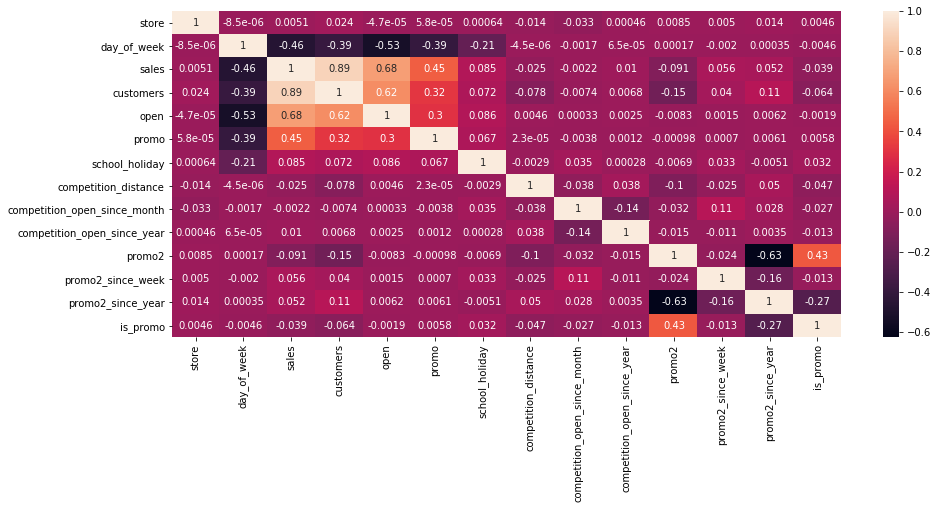

In [49]:
correlation = num_attributes.corr(method = 'pearson')

plt.figure(figsize=(15, 6))
sns.heatmap(correlation, annot = True);

### Categorical attributes

In [50]:
a = df4.select_dtypes(include = 'object')
a.head(2)

,state_holiday,store_type,assortment,year_week
0,regular_day,c,basic,2015-30
1,regular_day,a,basic,2015-30


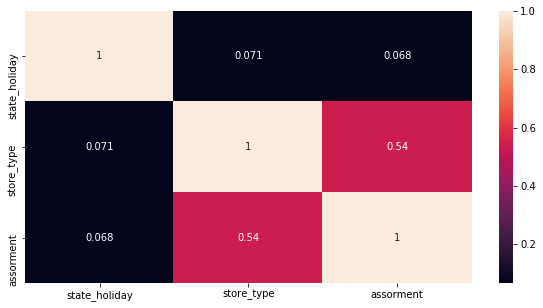

In [51]:
a1 = cramer_v(a['state_holiday'],a['state_holiday'])
a2 = cramer_v(a['state_holiday'],a['store_type'])
a3 = cramer_v(a['state_holiday'],a['assortment'])

a4 = cramer_v(a['store_type'],a['state_holiday'])
a5 = cramer_v(a['store_type'],a['store_type'])
a6 = cramer_v(a['store_type'],a['assortment'])

a7 = cramer_v(a['assortment'],a['state_holiday'])
a8 = cramer_v(a['assortment'],a['store_type'])
a9 = cramer_v(a['assortment'],a['assortment'])

d = pd.DataFrame({'state_holiday': [a1,a2,a3],
              'store_type': [a4,a5,a6],
              'assorment': [a7,a8,a9]
             })

d = d.set_index(d.columns)
plt.figure(figsize=(10, 5))
sns.heatmap(d , annot = True)

# DATA PREPARATION

In [52]:
df5 = df4.copy()

## Normalização

## Rescaling

In [53]:
a = df5.select_dtypes(include =['int64', 'float64'])
a.head(2)

,store,day_of_week,sales,promo,school_holiday,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo,year,month,day,week_of_year,competition_time_month,promo_time_week
0,1,5,5263,1,1,1270.0,9,2008,0,31,2015,0,2015,7,31,31,84,0
1,2,5,6064,1,1,570.0,11,2007,1,13,2010,1,2015,7,31,31,94,279


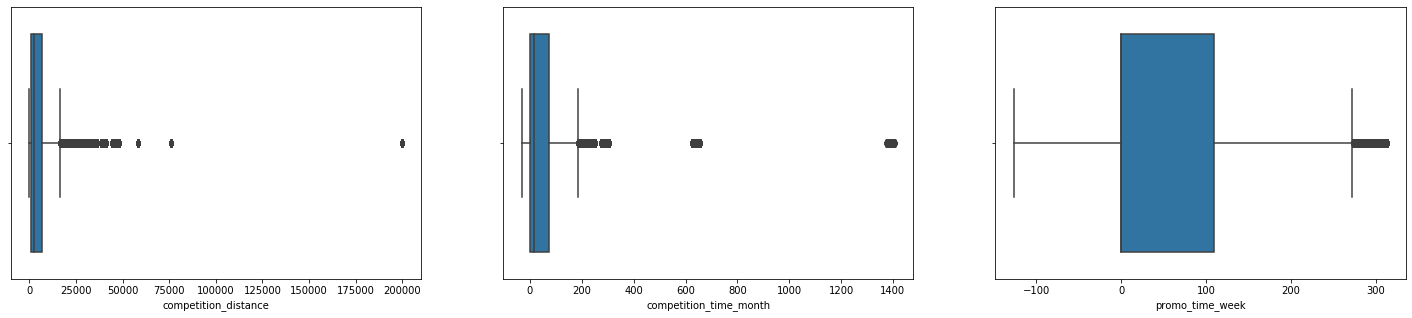

In [54]:
plt.figure(figsize=(25, 5))

plt.subplot(1, 3, 1)
sns.boxplot(df5['competition_distance'])

plt.subplot(1, 3, 2)
sns.boxplot(df5['competition_time_month'])

plt.subplot(1, 3, 3)
sns.boxplot(df5['promo_time_week'])

In [55]:
rs = RobustScaler()
mms = MinMaxScaler()

# competition distance
df5['competition_distance'] = rs.fit_transform(df5[['competition_distance']].values)

#competition time month
df5['competition_time_month'] = rs.fit_transform(df5[['competition_time_month']].values)

# promo time week
df5['promo_time_week'] = mms.fit_transform(df5[['promo_time_week']].values)

# year
df5['year'] = mms.fit_transform(df5[['year']].values)

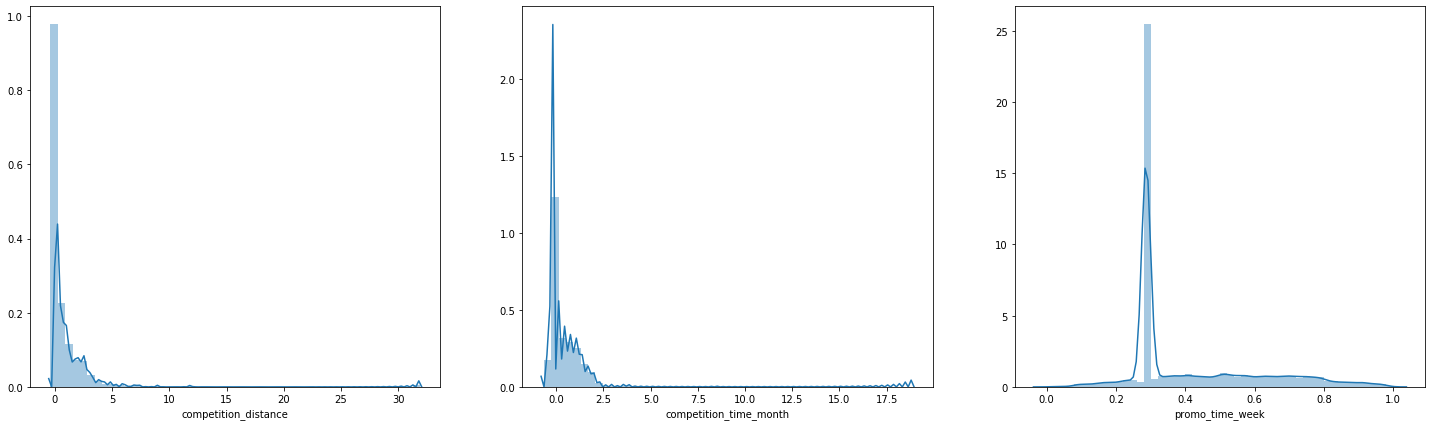

In [56]:
plt.figure(figsize=(25, 7))

plt.subplot(1, 3, 1)
sns.distplot(df5['competition_distance'])

plt.subplot(1, 3, 2)
sns.distplot(df5['competition_time_month'])

plt.subplot(1, 3, 3)
sns.distplot(df5['promo_time_week'])

## Transformação

### Encoding

In [57]:
# state_holiday - One Hot Encoding
df5 = pd.get_dummies (df5, prefix=['state_holiday'], columns = ['state_holiday'])

# store_type - Label enconding

le = LabelEncoder()
df5['store_type'] = le.fit_transform(df5['store_type'])

# assortment - Ordinal encoding
assortment_dict = {'basic' : 1,
                  'extra' : 2,
                  'extended' : 3}

df5['assortment'] = df5['assortment'].map(assortment_dict)

df5.head()

,store,day_of_week,date,sales,promo,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,...,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week,state_holiday_christimas,state_holiday_easter_holiday,state_holiday_public_holiday,state_holiday_regular_day
0,1,5,2015-07-31,5263,1,1,2,1,-0.170968,9,...,31,2015-30,2008-09-01,0.918919,2015-07-27,0.287016,0,0,0,1
1,2,5,2015-07-31,6064,1,1,0,1,-0.283871,11,...,31,2015-30,2007-11-01,1.054054,2010-03-22,0.922551,0,0,0,1
2,3,5,2015-07-31,8314,1,1,0,1,1.903226,12,...,31,2015-30,2006-12-01,1.202703,2011-03-28,0.801822,0,0,0,1
3,4,5,2015-07-31,13995,1,1,2,3,-0.275806,9,...,31,2015-30,2009-09-01,0.743243,2015-07-27,0.287016,0,0,0,1
4,5,5,2015-07-31,4822,1,1,0,1,4.448387,4,...,31,2015-30,2015-04-01,-0.162162,2015-07-27,0.287016,0,0,0,1


### Response Variable Transformation

In [58]:
df5['sales'] = np.log1p(df5['sales'])

### Nature Transformation

In [59]:
# day of week
df5['day_of_week_sin'] = df5['month'].apply(lambda x: np.sin (x * ( 2. * np.pi/7)))
df5['day_of_week_cos'] = df5['month'].apply(lambda x: np.sin (x * ( 2. * np.pi/7)))


# Month
df5['month_sin'] = df5['month'].apply(lambda x: np.sin (x * ( 2. * np.pi/12)))
df5['month_cos'] = df5['month'].apply(lambda x: np.sin (x * ( 2. * np.pi/12)))

# day
df5['day_sin'] = df5['day'].apply(lambda x: np.sin (x * ( 2. * np.pi/30)))
df5['day_cos'] = df5['day'].apply(lambda x: np.sin (x * ( 2. * np.pi/30)))

# week of year
df5['week_of_year_sin'] = df5['week_of_year'].apply(lambda x: np.sin (x * ( 2. * np.pi/52)))
df5['week_of_year_cos'] = df5['week_of_year'].apply(lambda x: np.sin (x * ( 2. * np.pi/52)))

In [60]:
df5.head(3)

,store,day_of_week,date,sales,promo,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,...,state_holiday_public_holiday,state_holiday_regular_day,day_of_week_sin,day_of_week_cos,month_sin,month_cos,day_sin,day_cos,week_of_year_sin,week_of_year_cos
0,1,5,2015-07-31,8.568646,1,1,2,1,-0.170968,9,...,0,1,-2.449294e-16,-2.449294e-16,-0.5,-0.5,0.207912,0.207912,-0.568065,-0.568065
1,2,5,2015-07-31,8.710290,1,1,0,1,-0.283871,11,...,0,1,-2.449294e-16,-2.449294e-16,-0.5,-0.5,0.207912,0.207912,-0.568065,-0.568065
2,3,5,2015-07-31,9.025816,1,1,0,1,1.903226,12,...,0,1,-2.449294e-16,-2.449294e-16,-0.5,-0.5,0.207912,0.207912,-0.568065,-0.568065


# FEATURE SELECTION

In [63]:
df6 = df5.copy()

## Split dataframe into training and test dataset

In [64]:
df6[['store', 'date']].groupby('store').max().reset_index()['date'][0] - datetime.timedelta(days=6*7)

Timestamp('2015-06-19 00:00:00')

In [66]:
# Training dataset
X_train = df6[df6['date'] < '2015-06-19']
y_train = X_train['sales']

# teste dataset
X_test = df6[df6['date'] >= '2015-06-19']
y_test = X_test['sales']

print('Training min date: {}'.format(X_train['date'].min()))
print('Training max date: {}'.format(X_train['date'].max()))

print('Test min date: {}'.format(X_test['date'].min()))
print('Test min date: {}'.format(X_test['date'].max()))
      

Training min date: 2013-01-01 00:00:00
Training max date: 2015-06-18 00:00:00
Test min date: 2015-06-19 00:00:00
Test min date: 2015-07-31 00:00:00


## Boruta as Feature Selector

In [ ]:
cols_drop = ['week_of_year' ,'day', 'month', 'day_of_week', 'promo_since', 'competition_since', 'year_week']
df6 = df6.drop(cols_drop, axis = 1)